In [10]:
# !pip install -q xgboost==1.7.6

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

In [8]:
df_red = pd.read_csv("winequality-red.csv", sep=";")
df_red["wine_type"] = "red"

df_white = pd.read_csv("winequality-white.csv", sep=";")
df_white["wine_type"] = "white"

df = pd.concat([df_red, df_white], ignore_index=True)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [12]:
# Basic info
print("\n📋 Dataset Info:")
print(df.info())

print("\n📊 Statistical Summary:")
print(df.describe())

# Check missing values
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values found!")
else:
    print(missing[missing > 0])

# Check duplicates
duplicates = df.duplicated().sum()
print(f"\n🔄 Duplicate Rows: {duplicates}")
if duplicates > 0:
    print(f"   Removing {duplicates} duplicates...")
    df = df.drop_duplicates()
    print(f"   New shape: {df.shape}")

# Target distribution
print("\n🎯 Quality Distribution:")
print(df['quality'].value_counts().sort_index())

print("\n📊 Quality Statistics:")
print(f"   Min quality: {df['quality'].min()}")
print(f"   Max quality: {df['quality'].max()}")
print(f"   Mean quality: {df['quality'].mean():.2f}")
print(f"   Median quality: {df['quality'].median():.2f}")

# Wine type distribution
print("\n🍷 Wine Type Distribution:")
print(df['wine_type'].value_counts())



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5320 non-null   float64
 1   volatile acidity      5320 non-null   float64
 2   citric acid           5320 non-null   float64
 3   residual sugar        5320 non-null   float64
 4   chlorides             5320 non-null   float64
 5   free sulfur dioxide   5320 non-null   float64
 6   total sulfur dioxide  5320 non-null   float64
 7   density               5320 non-null   float64
 8   pH                    5320 non-null   float64
 9   sulphates             5320 non-null   float64
 10  alcohol               5320 non-null   float64
 11  quality               5320 non-null   int64  
 12  wine_type             5320 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 581.9+ KB
None

📊 Statistical Summary:
       fixed acidity  

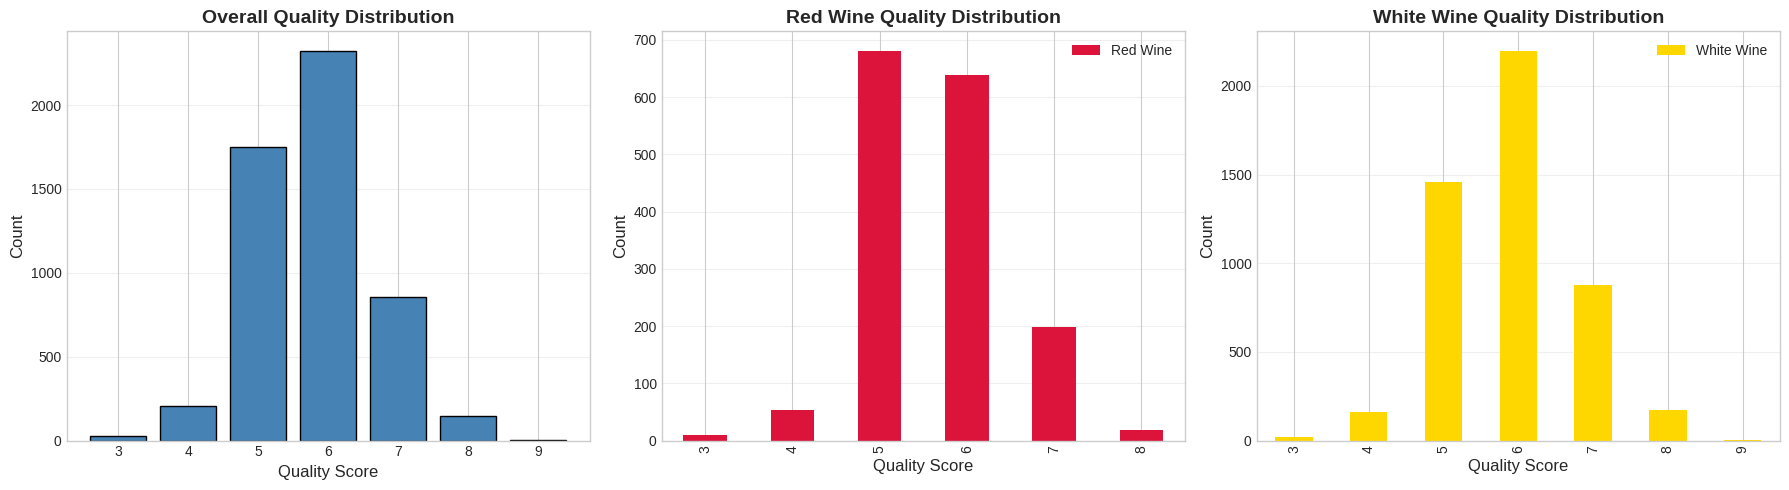


💡 Insight 1 - Quality Distribution:
- Kebanyakan wine memiliki quality score 5-6 (normal wines)
- Quality score 3 dan 9 sangat jarang (extreme quality)
- White wine memiliki distribusi lebih merata
- Data imbalanced → perlu dipertimbangkan dalam modeling

--------------------------------------------------------------------------------


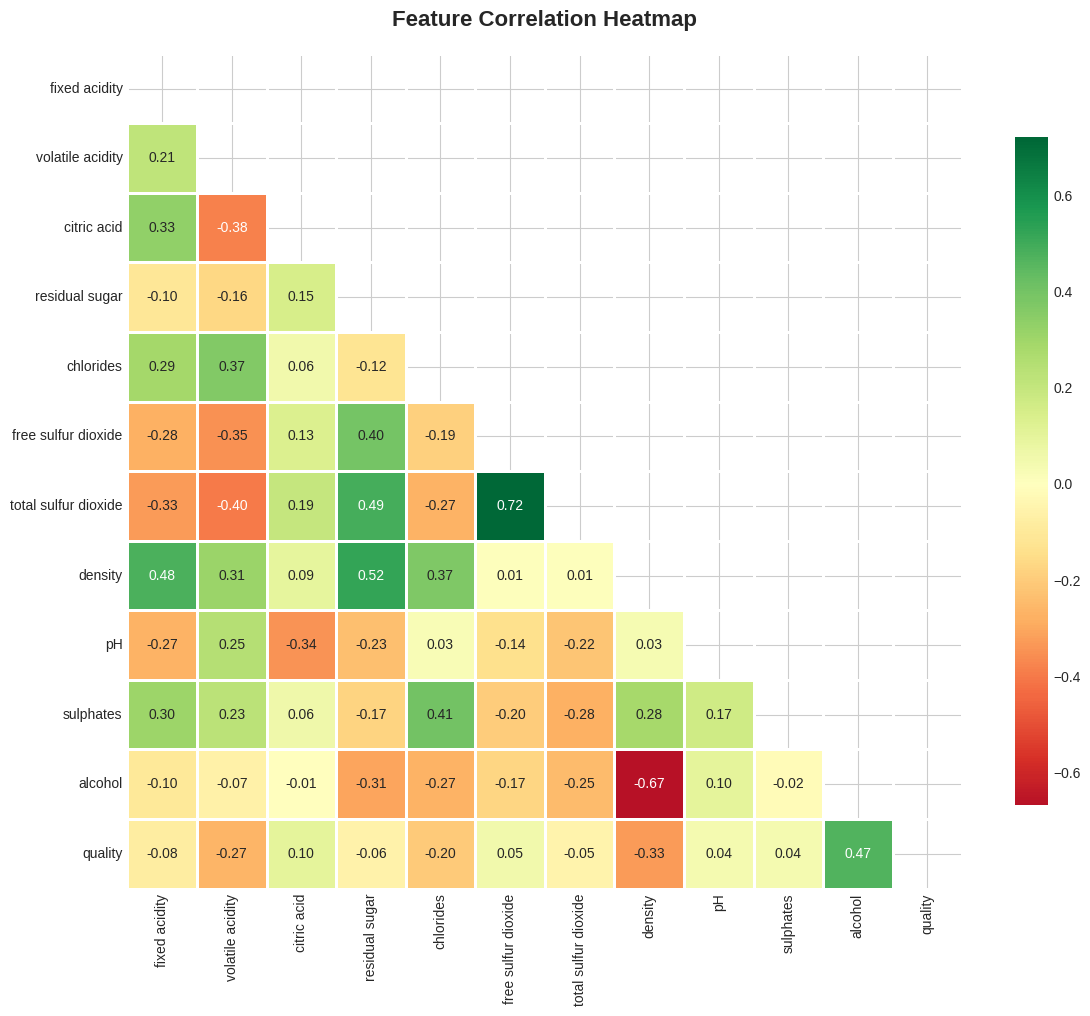


💡 Insight 2 - Correlation with Quality:
quality                 1.000000
alcohol                 0.469422
citric acid             0.097954
free sulfur dioxide     0.054002
sulphates               0.041884
pH                      0.039733
total sulfur dioxide   -0.050296
residual sugar         -0.056830
fixed acidity          -0.080092
chlorides              -0.202137
volatile acidity       -0.265205
density                -0.326434
Name: quality, dtype: float64

Top positive correlations:
quality                1.000000
alcohol                0.469422
citric acid            0.097954
free sulfur dioxide    0.054002
sulphates              0.041884
pH                     0.039733
Name: quality, dtype: float64

Top negative correlations:
total sulfur dioxide   -0.050296
residual sugar         -0.056830
fixed acidity          -0.080092
Name: quality, dtype: float64


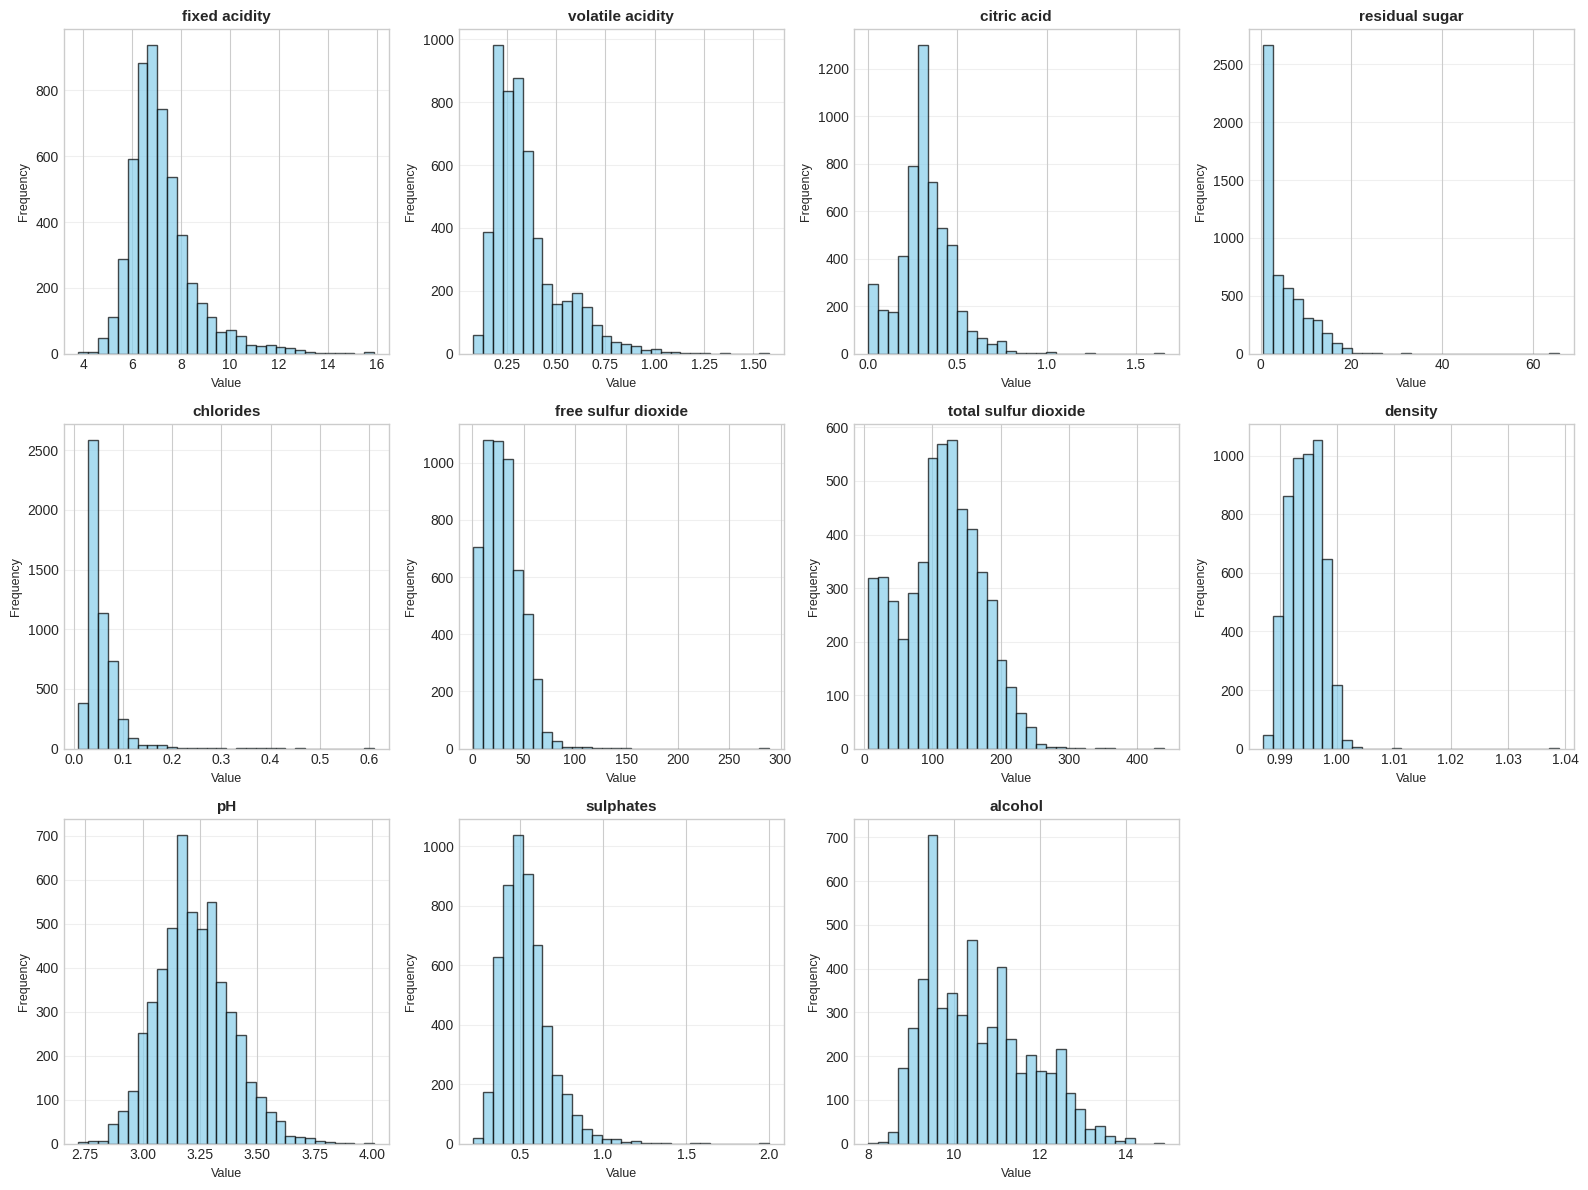


💡 Insight 3 - Feature Distributions:
- Beberapa fitur memiliki outliers (perlu handling)
- Distribusi tidak uniform → scaling diperlukan
- 'residual sugar' dan 'chlorides' right-skewed


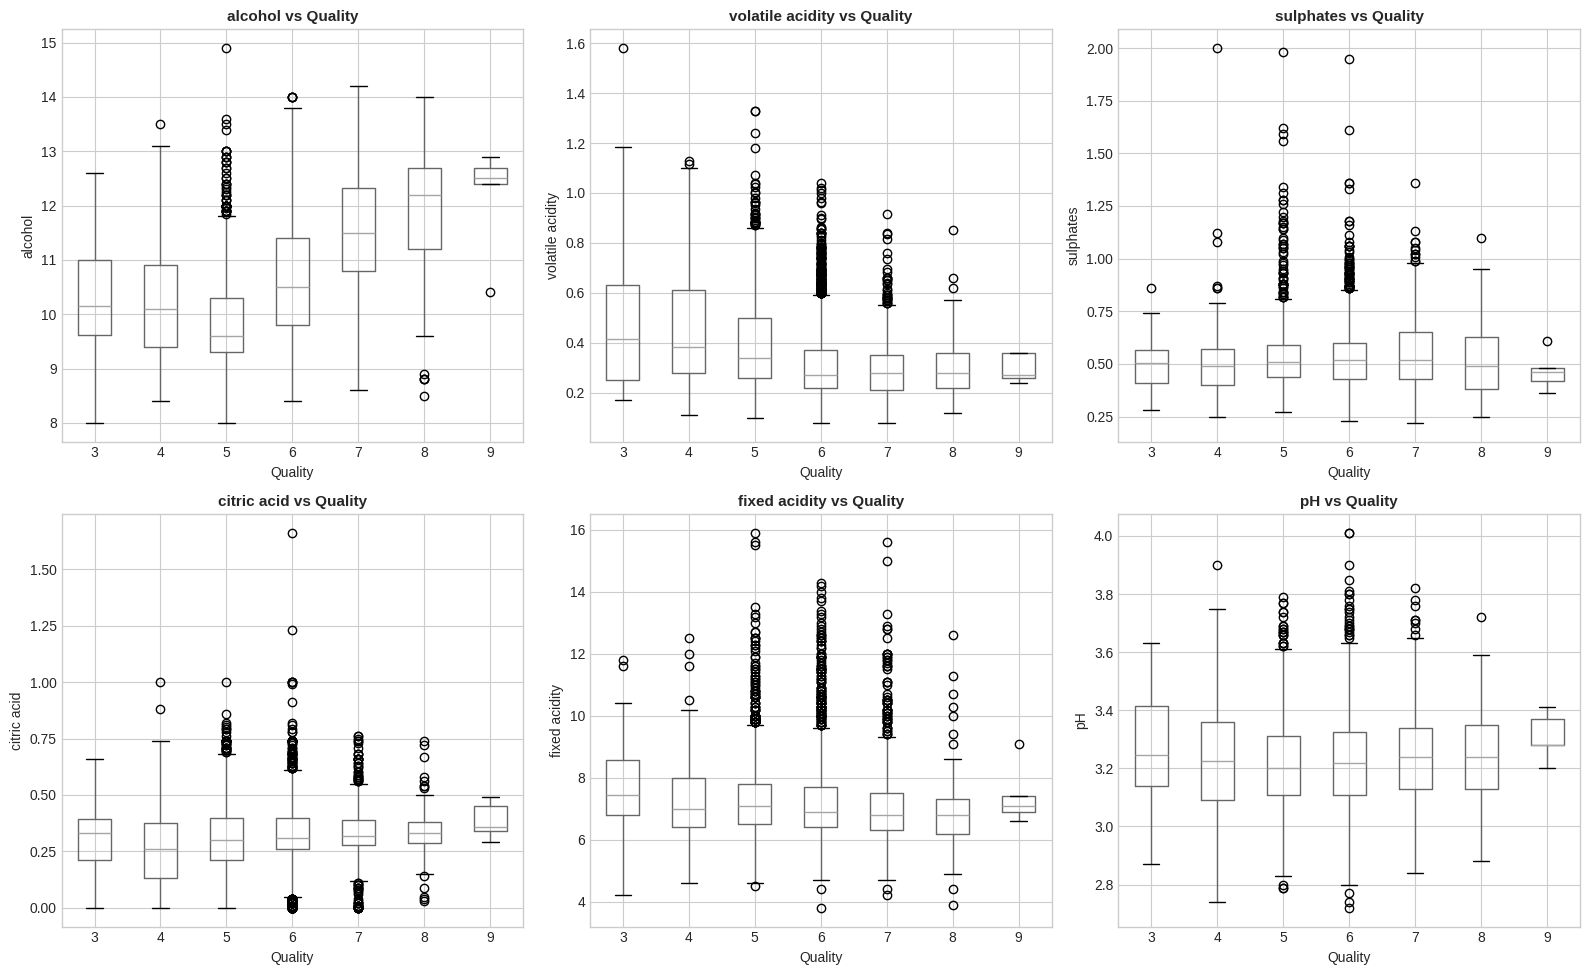


💡 Insight 4 - Features vs Quality:
- Higher alcohol → higher quality (positive correlation)
- Lower volatile acidity → higher quality
- Higher sulphates → slightly higher quality
- Citric acid varies with quality


In [13]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# EDA 1: Quality Distribution by Wine Type
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Overall quality distribution
quality_counts = df['quality'].value_counts().sort_index()
axes[0].bar(quality_counts.index, quality_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Quality Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Overall Quality Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Quality by wine type
df_red['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[1],
                                                     color='crimson', label='Red Wine')
axes[1].set_xlabel('Quality Score', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Red Wine Quality Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

df_white['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[2],
                                                       color='gold', label='White Wine')
axes[2].set_xlabel('Quality Score', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('White Wine Quality Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('quality_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Insight 1 - Quality Distribution:")
print("- Kebanyakan wine memiliki quality score 5-6 (normal wines)")
print("- Quality score 3 dan 9 sangat jarang (extreme quality)")
print("- White wine memiliki distribusi lebih merata")
print("- Data imbalanced → perlu dipertimbangkan dalam modeling")

# EDA 2: Correlation Heatmap
print("\n" + "-"*80)
features_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = features_numeric.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdYlGn', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation with quality
quality_corr = correlation_matrix['quality'].sort_values(ascending=False)
print("\n💡 Insight 2 - Correlation with Quality:")
print(quality_corr)
print("\nTop positive correlations:")
print(quality_corr[quality_corr > 0].head(6))
print("\nTop negative correlations:")
print(quality_corr[quality_corr < 0].head(3))

# EDA 3: Feature Distributions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

feature_cols = [col for col in df.columns if col not in ['quality', 'wine_type']]

for idx, col in enumerate(feature_cols):
    if idx < len(axes):
        df[col].hist(bins=30, ax=axes[idx], color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)
        axes[idx].grid(axis='y', alpha=0.3)

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Insight 3 - Feature Distributions:")
print("- Beberapa fitur memiliki outliers (perlu handling)")
print("- Distribusi tidak uniform → scaling diperlukan")
print("- 'residual sugar' dan 'chlorides' right-skewed")

# EDA 4: Box plots for key features vs Quality
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

key_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid',
                'fixed acidity', 'pH']

for idx, feature in enumerate(key_features):
    df.boxplot(column=feature, by='quality', ax=axes[idx])
    axes[idx].set_title(f'{feature} vs Quality', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Quality', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    plt.sca(axes[idx])
    plt.xticks(rotation=0)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('boxplot_features_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Insight 4 - Features vs Quality:")
print("- Higher alcohol → higher quality (positive correlation)")
print("- Lower volatile acidity → higher quality")
print("- Higher sulphates → slightly higher quality")
print("- Citric acid varies with quality")

In [14]:
# Encode wine_type
df['wine_type_encoded'] = df['wine_type'].map({'red': 0, 'white': 1})

# Separate features and target
X = df.drop(['quality', 'wine_type'], axis=1)
y = df['quality']

print(f"\n✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")

# Feature columns
print("\n📋 Feature columns:")
print(X.columns.tolist())

# Handle outliers using IQR method
print("\n🔧 Handling outliers...")
def remove_outliers_iqr(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Apply outlier removal
outlier_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']

original_size = len(X)
df_combined = pd.concat([X, y], axis=1)
df_clean = remove_outliers_iqr(df_combined, outlier_cols, threshold=2.0)

X_clean = df_clean.drop('quality', axis=1)
y_clean = df_clean['quality']

print(f"   Original size: {original_size}")
print(f"   After outlier removal: {len(X_clean)}")
print(f"   Removed: {original_size - len(X_clean)} samples ({(original_size - len(X_clean))/original_size*100:.2f}%)")

# Use cleaned data
X = X_clean
y = y_clean

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📊 Train set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Feature scaling completed (StandardScaler)")
print(f"   Mean: {X_train_scaled.mean():.6f}")
print(f"   Std: {X_train_scaled.std():.6f}")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\n💾 Scaler saved to 'scaler.pkl'")


✅ Features shape: (5320, 12)
✅ Target shape: (5320,)

📋 Feature columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'wine_type_encoded']

🔧 Handling outliers...
   Original size: 5320
   After outlier removal: 4624
   Removed: 696 samples (13.08%)

📊 Train set: 3699 samples
📊 Test set: 925 samples

✅ Feature scaling completed (StandardScaler)
   Mean: 0.000000
   Std: 1.000000

💾 Scaler saved to 'scaler.pkl'



🔧 Training Linear Regression...

✅ Training completed in 0.0386 seconds

📊 Linear Regression Performance:
   MAE (Mean Absolute Error): 0.5633
   MSE (Mean Squared Error):  0.5451
   RMSE (Root MSE):           0.7383
   R² Score:                  0.2788

   Training MAE: 0.5583
   Training R²:  0.3188

📊 Feature Coefficients (by importance):
                 Feature  Coefficient
7                density    -0.395634
3         residual sugar     0.309048
10               alcohol     0.232317
11     wine_type_encoded    -0.170694
1       volatile acidity    -0.167708
5    free sulfur dioxide     0.141735
8                     pH     0.126205
0          fixed acidity     0.119880
9              sulphates     0.106370
6   total sulfur dioxide    -0.079229
4              chlorides    -0.031655
2            citric acid     0.014023


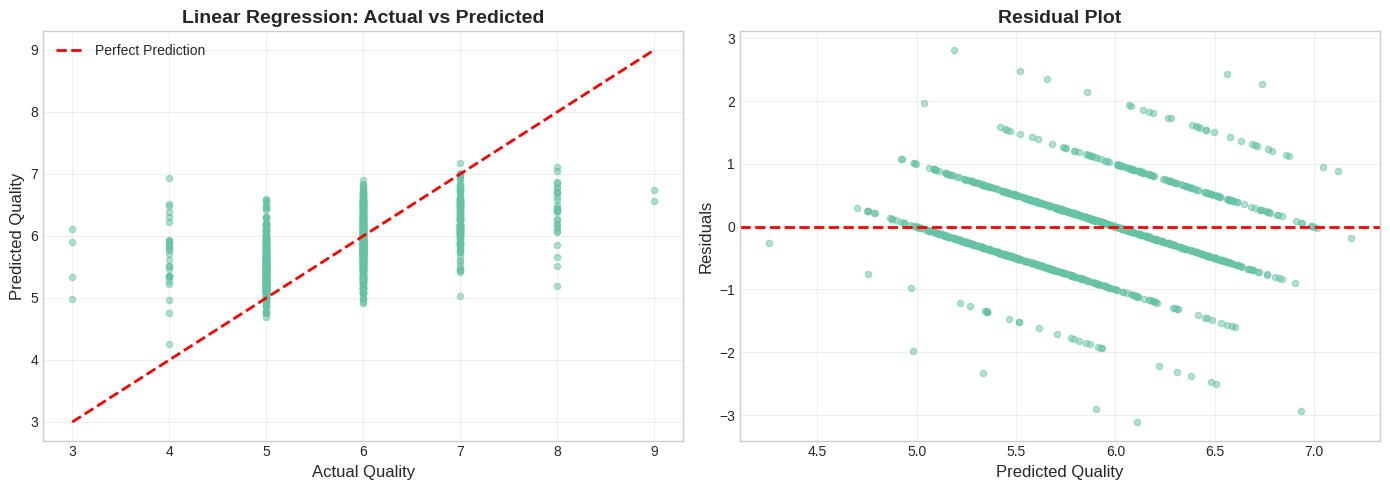


💾 Model saved to 'model_baseline.pkl'


In [15]:
# Train Linear Regression
lr_model = LinearRegression()

print("\n🔧 Training Linear Regression...")
import time
start_time = time.time()
lr_model.fit(X_train_scaled, y_train)
training_time_lr = time.time() - start_time

# Predictions
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\n✅ Training completed in {training_time_lr:.4f} seconds")
print("\n📊 Linear Regression Performance:")
print(f"   MAE (Mean Absolute Error): {mae_lr:.4f}")
print(f"   MSE (Mean Squared Error):  {mse_lr:.4f}")
print(f"   RMSE (Root MSE):           {rmse_lr:.4f}")
print(f"   R² Score:                  {r2_lr:.4f}")

# Training vs Test
mae_train_lr = mean_absolute_error(y_train, y_pred_lr_train)
r2_train_lr = r2_score(y_train, y_pred_lr_train)
print(f"\n   Training MAE: {mae_train_lr:.4f}")
print(f"   Training R²:  {r2_train_lr:.4f}")

# Coefficient analysis
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n📊 Feature Coefficients (by importance):")
print(coef_df)

# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Quality', fontsize=12)
axes[0].set_ylabel('Predicted Quality', fontsize=12)
axes[0].set_title('Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Quality', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lr_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
with open('model_baseline.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("\n💾 Model saved to 'model_baseline.pkl'")


🔧 Training XGBoost...

✅ Training completed in 4.9600 seconds

📊 XGBoost Performance:
   MAE (Mean Absolute Error): 0.5404
   MSE (Mean Squared Error):  0.5037
   RMSE (Root MSE):           0.7097
   R² Score:                  0.3336

   Training MAE: 0.3083
   Training R²:  0.7888

📊 Feature Importance:
                 Feature  Importance
10               alcohol    0.227420
11     wine_type_encoded    0.154934
7                density    0.090581
5    free sulfur dioxide    0.078806
1       volatile acidity    0.068445
9              sulphates    0.063117
3         residual sugar    0.060725
6   total sulfur dioxide    0.056153
2            citric acid    0.055925
8                     pH    0.053414
4              chlorides    0.052472
0          fixed acidity    0.038008


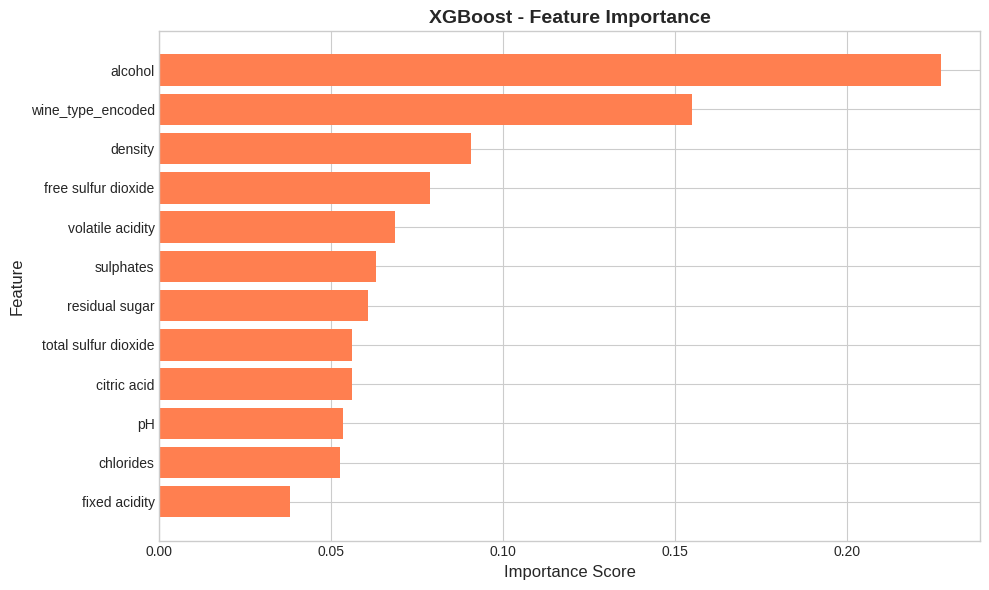

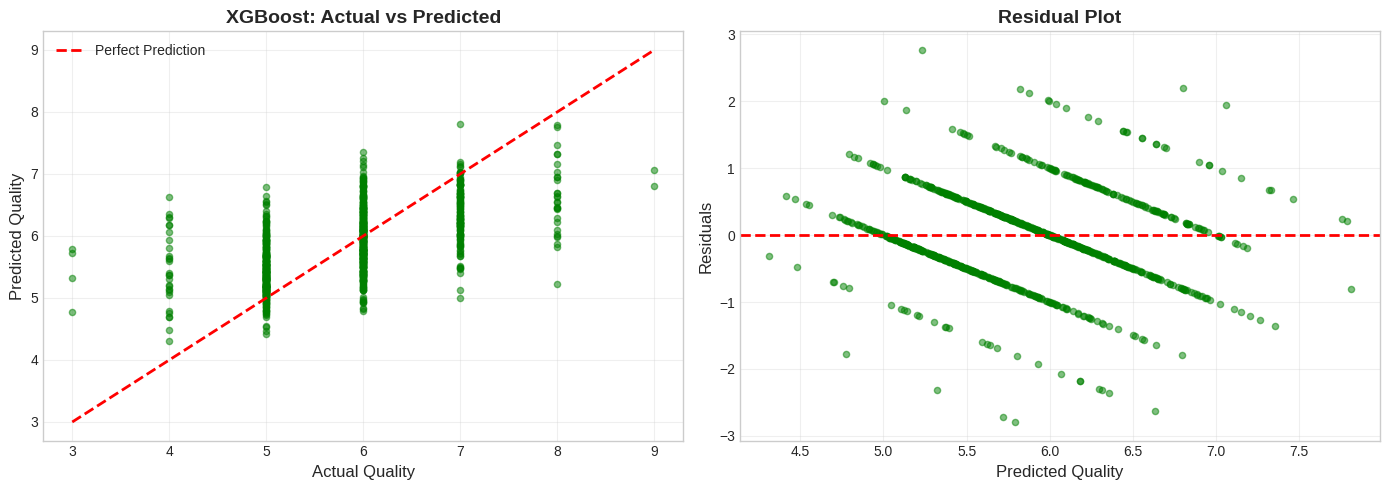


💾 Model saved to 'model_xgboost.pkl'


In [18]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("\n🔧 Training XGBoost...")
start_time = time.time()
xgb_model.fit(X_train_scaled, y_train,
              eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
              verbose=False)
training_time_xgb = time.time() - start_time

# Predictions
y_pred_xgb_train = xgb_model.predict(X_train_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n✅ Training completed in {training_time_xgb:.4f} seconds")
print("\n📊 XGBoost Performance:")
print(f"   MAE (Mean Absolute Error): {mae_xgb:.4f}")
print(f"   MSE (Mean Squared Error):  {mse_xgb:.4f}")
print(f"   RMSE (Root MSE):           {rmse_xgb:.4f}")
print(f"   R² Score:                  {r2_xgb:.4f}")

# Training vs Test
mae_train_xgb = mean_absolute_error(y_train, y_pred_xgb_train)
r2_train_xgb = r2_score(y_train, y_pred_xgb_train)
print(f"\n   Training MAE: {mae_train_xgb:.4f}")
print(f"   Training R²:  {r2_train_xgb:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Feature Importance:")
print(feature_importance)

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost - Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_xgb, alpha=0.5, s=20, color='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Quality', fontsize=12)
axes[0].set_ylabel('Predicted Quality', fontsize=12)
axes[0].set_title('XGBoost: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals_xgb = y_test - y_pred_xgb
axes[1].scatter(y_pred_xgb, residuals_xgb, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Quality', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('xgb_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
with open('model_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("\n💾 Model saved to 'model_xgboost.pkl'")


MODEL 3: DEEP LEARNING - NEURAL NETWORK

🏗️ Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)


🔧 Training Neural Network...
Epoch 1/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 25.4242 - mae: 4.7431 - val_loss: 1.8490 - val_mae: 1.0672 - learning_rate: 0.0010
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8026 - mae: 1.3187 - val_loss: 1.4226 - val_mae: 0.9505 - learning_rate: 0.0010
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3356 - mae: 1.2124 - val_loss: 1.2544 - val_mae: 0.8915 - learning_rate: 0.0010
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0734 - mae: 1.1470 - val_loss: 1.0953 - val_mae: 0.8317 - learning_rate: 0.0010
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7694 - mae: 1.0561 - val_loss: 1.0202 - val_mae: 0.8048 - learning_rate: 0.0010
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6646 - mae: 1.0303 - val_loss: 0.9391 - val_mae: 0.7743 - learning_rate: 0.0010
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3828 - mae: 0.9324 - val_loss: 0.8693 - val_mae: 0.7419 - l

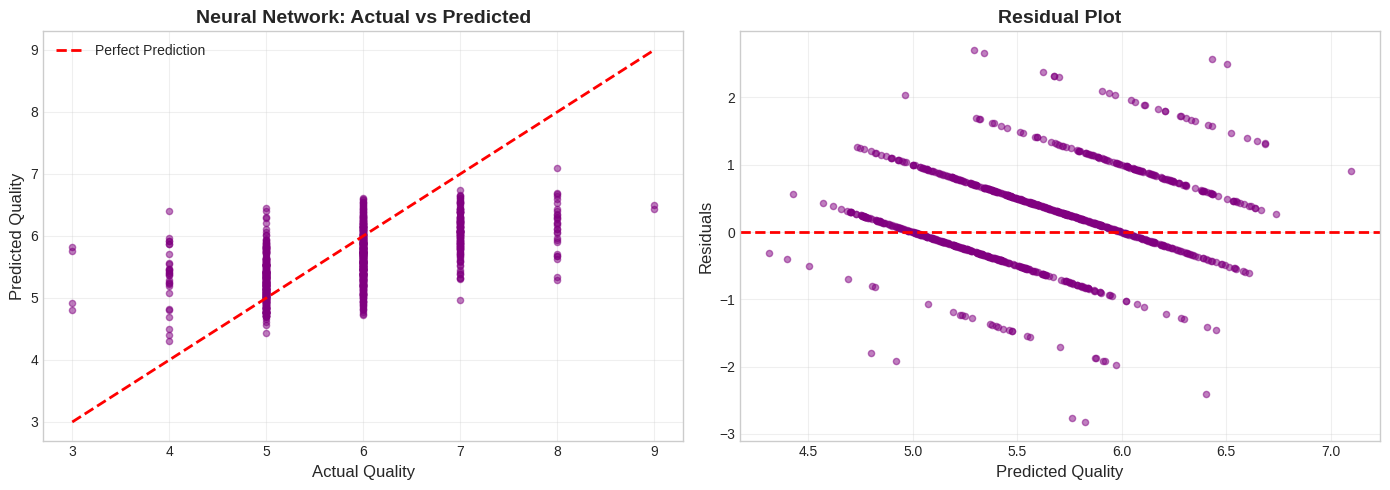


💾 Model saved to 'model_nn.h5'


In [17]:
# Build Neural Network for Regression
def build_nn_regression(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dropout(0.3, name='dropout_1'),
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dropout(0.3, name='dropout_2'),
        layers.Dense(32, activation='relu', name='dense_3'),
        layers.Dense(1, name='output')  # Linear activation for regression
    ])
    return model

# Create model
nn_model = build_nn_regression(input_dim=X_train_scaled.shape[1])

# Model summary
print("\n🏗️ Neural Network Architecture:")
nn_model.summary()

# Compile model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

# Train model
print("\n🔧 Training Neural Network...")
start_time = time.time()

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time_nn = time.time() - start_time
print(f"\n✅ Training completed in {training_time_nn:.2f} seconds")

# Predictions
y_pred_nn_train = nn_model.predict(X_train_scaled, verbose=0).flatten()
y_pred_nn = nn_model.predict(X_test_scaled, verbose=0).flatten()

# Evaluation
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("\n📊 Neural Network Performance:")
print(f"   MAE (Mean Absolute Error): {mae_nn:.4f}")
print(f"   MSE (Mean Squared Error):  {mse_nn:.4f}")
print(f"   RMSE (Root MSE):           {rmse_nn:.4f}")
print(f"   R² Score:                  {r2_nn:.4f}")

# Training vs Test
mae_train_nn = mean_absolute_error(y_train, y_pred_nn_train)
r2_train_nn = r2_score(y_train, y_pred_nn_train)
print(f"\n   Training MAE: {mae_train_nn:.4f}")
print(f"   Training R²:  {r2_train_nn:.4f}")

# Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_nn, alpha=0.5, s=20, color='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Quality', fontsize=12)
axes[0].set_ylabel('Predicted Quality', fontsize=12)
axes[0].set_title('Neural Network: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals_nn = y_test - y_pred_nn
axes[1].scatter(y_pred_nn, residuals_nn, alpha=0.5, s=20, color='purple')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Quality', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('nn_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
nn_model.save('model_nn.h5')
print("\n💾 Model saved to 'model_nn.h5'")

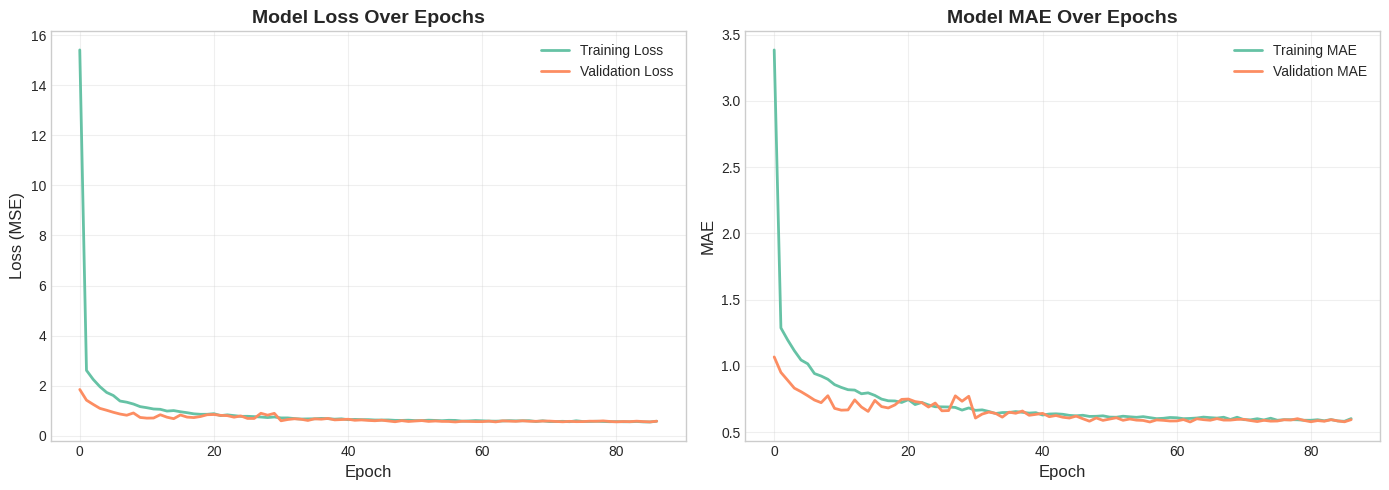


💡 Training Analysis:
- Model converged early at epoch 87
- Early stopping prevented overfitting
✅ No significant overfitting detected


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Training Analysis:")
epochs_trained = len(history.history['loss'])
if epochs_trained < 150:
    print(f"- Model converged early at epoch {epochs_trained}")
    print("- Early stopping prevented overfitting")
else:
    print("- Model trained for full 150 epochs")

# Check overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
if final_val_loss > final_train_loss * 1.3:
    print("⚠️ Model shows slight overfitting")
else:
    print("✅ No significant overfitting detected")



📊 Performance Comparison:
            Model      MAE     RMSE  R² Score  Training Time (s)
Linear Regression 0.563285 0.738342  0.278795           0.038581
          XGBoost 0.540364 0.709718  0.333632           4.959960
   Neural Network 0.559492 0.737080  0.281260          49.536503


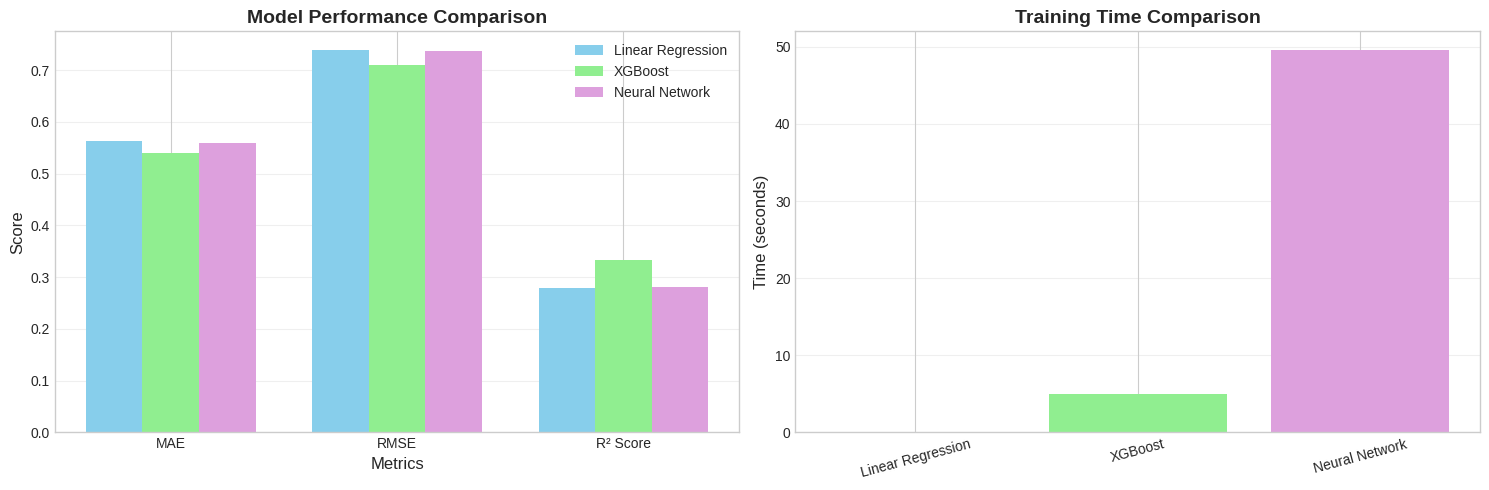

In [21]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'Neural Network'],
    'MAE': [mae_lr, mae_xgb, mae_nn],
    'RMSE': [rmse_lr, rmse_xgb, rmse_nn],
    'R² Score': [r2_lr, r2_xgb, r2_nn],
    'Training Time (s)': [training_time_lr, training_time_xgb, training_time_nn]
})

print("\n📊 Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Metrics comparison
metrics = ['MAE', 'RMSE', 'R² Score']
x = np.arange(len(metrics))
width = 0.25

colors = ['skyblue', 'lightgreen', 'plum']
for i, model in enumerate(['Linear Regression', 'XGBoost', 'Neural Network']):
    values = comparison_df[comparison_df['Model'] == model][metrics].values[0]
    axes[0].bar(x + i*width, values, width, label=model, color=colors[i])

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Training time comparison
axes[1].bar(comparison_df['Model'], comparison_df['Training Time (s)'],
           color=colors)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()